# Gradient Boost Machine For Paddy

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [55]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names=None, eps=1e-6):
        self.feature_names = feature_names
        self.eps = eps
        self._indices = None
        self._feature_names = None
        self._new_feature_names = [
            "Area_Total",
            "Area_K_over_S",
            "Area_K_over_H",
            "Area_S_over_H",
            "Green_over_Red"
        ]

    def fit(self, X, y=None):
        if self.feature_names is None:
            if hasattr(X, "columns"):
                self._feature_names = list(X.columns)
            else:
                self._feature_names = [f"f{i}" for i in range(X.shape[1])]
        else:
            self._feature_names = list(self.feature_names)
        name_to_idx = {name: idx for idx, name in enumerate(self._feature_names)}
        required = ["Area_K", "Area_S", "Area_H", "GreenIndex_K", "RedIndex_K"]
        missing = [name for name in required if name not in name_to_idx]
        if missing:
            raise ValueError(f"Missing required features: {missing}")
        self._indices = name_to_idx
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        idx = self._indices
        area_k = X[:, idx["Area_K"]]
        area_s = X[:, idx["Area_S"]]
        area_h = X[:, idx["Area_H"]]
        green = X[:, idx["GreenIndex_K"]]
        red = X[:, idx["RedIndex_K"]]

        area_total = area_k + area_s + area_h
        area_k_over_s = area_k / (area_s + self.eps)
        area_k_over_h = area_k / (area_h + self.eps)
        area_s_over_h = area_s / (area_h + self.eps)
        green_over_red = green / (red + self.eps)

        engineered = np.column_stack([
            area_total,
            area_k_over_s,
            area_k_over_h,
            area_s_over_h,
            green_over_red,
        ])
        return np.column_stack([X, engineered])

    def get_feature_names_out(self):
        return self._feature_names + self._new_feature_names


## Data Preprocessing

In [56]:
df = pd.read_csv("DatasetsPKM.csv")
df.head()

,Area_K,Area_S,Area_H,RedIndex_K,GreenIndex_K,RGR_S,VARI_S,MTS
0,"1,41","0,33","5,25","0,08","0,89","1,05","-0,03",5
1,"9,21","2,59","12,1","0,38","0,45","0,87","0,08",1
2,"3,58","1,09","1,37","0,4","0,44","0,99","0,01",1
3,"9,64","0,59","2,82","0,38","0,45","1,03","-0,02",5
4,"26,6","3,13","10,3","0,37","0,47","1,06","-0,04",1


In [57]:
numeric_cols = df.select_dtypes(include=["object", "string"]).columns
df[numeric_cols] = df[numeric_cols].replace(",", ".", regex=True).astype(float)

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area_K        148 non-null    float64
 1   Area_S        148 non-null    float64
 2   Area_H        148 non-null    float64
 3   RedIndex_K    148 non-null    float64
 4   GreenIndex_K  148 non-null    float64
 5   RGR_S         148 non-null    float64
 6   VARI_S        148 non-null    float64
 7   MTS           148 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 9.4 KB


In [58]:
df.isnull().sum()

Area_K          0
Area_S          0
Area_H          0
RedIndex_K      0
GreenIndex_K    0
RGR_S           0
VARI_S          0
MTS             0
dtype: int64

In [59]:
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Duplicate rows: 0


In [60]:
X = df.drop(columns=["MTS"])
y = df["MTS"].astype(int)

In [61]:
feature_engineer = FeatureEngineer(feature_names=X.columns)
X_fe = feature_engineer.fit_transform(X)
feature_names_fe = feature_engineer.get_feature_names_out()
k_best = min(8, X_fe.shape[1])

## Feature Analysis

In [62]:
df.describe()

,Area_K,Area_S,Area_H,RedIndex_K,GreenIndex_K,RGR_S,VARI_S,MTS
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,12.629257,9.840338,17.534324,0.371622,0.460203,0.915878,0.054662,1.783784
std,10.382281,7.260507,13.119642,0.025848,0.038747,0.052914,0.034254,1.203965
min,0.640000,0.330000,0.830000,0.080000,0.390000,0.770000,-0.110000,1.000000
25%,4.430000,3.527500,7.352500,0.370000,0.450000,0.880000,0.040000,1.000000
50%,10.250000,8.090000,14.850000,0.370000,0.460000,0.910000,0.060000,1.000000
75%,18.775000,15.025000,24.600000,0.380000,0.470000,0.942500,0.080000,3.000000
max,50.800000,31.000000,62.800000,0.400000,0.890000,1.190000,0.160000,5.000000


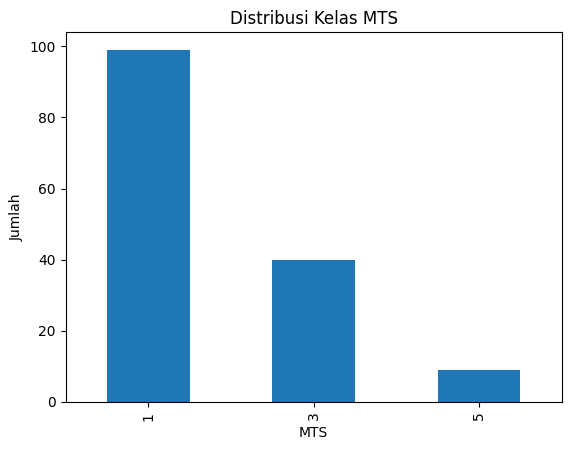

In [63]:
class_counts = y.value_counts().sort_index()
class_counts.plot(kind="bar")
plt.title("Distribusi Kelas MTS")
plt.xlabel("MTS")
plt.ylabel("Jumlah")
plt.show()

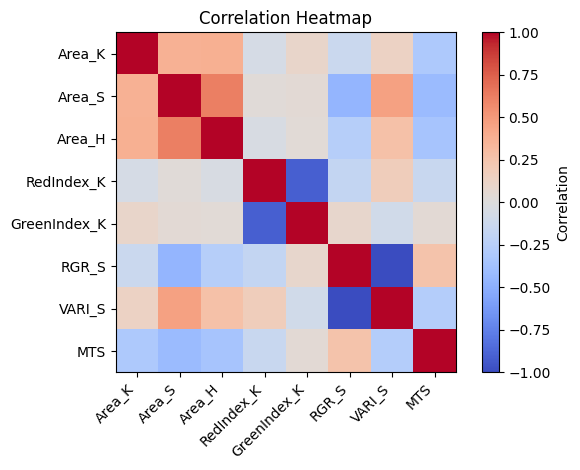

In [64]:
corr = df.corr(numeric_only=True)

plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [65]:
target_corr = corr["MTS"].drop("MTS").sort_values(ascending=False)
target_corr

RGR_S           0.251803
GreenIndex_K    0.046152
RedIndex_K     -0.141676
VARI_S         -0.267354
Area_K         -0.308462
Area_H         -0.348018
Area_S         -0.418619
Name: MTS, dtype: float64

In [66]:
leakage_threshold = 0.95
potential_leakage = target_corr[abs(target_corr) > leakage_threshold]
potential_leakage

Series([], Name: MTS, dtype: float64)

## Feature Selection

In [67]:
selector = SelectKBest(mutual_info_classif, k=k_best)
selector.fit(X_fe, y)

feature_scores = pd.Series(selector.scores_, index=feature_names_fe).sort_values(ascending=False)
feature_scores

Area_S            0.157448
Area_K            0.132866
Area_Total        0.129843
RGR_S             0.112412
Area_S_over_H     0.097044
GreenIndex_K      0.076317
Area_H            0.053339
Green_over_Red    0.032179
VARI_S            0.030208
RedIndex_K        0.026058
Area_K_over_S     0.000000
Area_K_over_H     0.000000
dtype: float64

In [68]:
selected_features = [name for name, keep in zip(feature_names_fe, selector.get_support()) if keep]
selected_features

['Area_K',
 'Area_S',
 'Area_H',
 'GreenIndex_K',
 'RGR_S',
 'Area_Total',
 'Area_S_over_H',
 'Green_over_Red']

## Cross Validation

In [69]:
pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("feature_engineer", FeatureEngineer(feature_names=X.columns)),
    ("scaler", MinMaxScaler()),
    ("select", SelectKBest(mutual_info_classif, k=k_best)),
    ("model", GradientBoostingClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y)
roc_auc_scorer = make_scorer(
    roc_auc_score, response_method="predict_proba", multi_class="ovr", average="macro"
)
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted",
    "roc_auc_ovr_macro": roc_auc_scorer
}
cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    params={"model__sample_weight": sample_weight}
)

pd.DataFrame(cv_results).agg(["mean", "std"])

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted,test_roc_auc_ovr_macro
mean,0.123592,0.007660,0.622989,0.482807,0.478584,0.621972,0.731326
std,0.008660,0.001823,0.112424,0.196886,0.199710,0.105795,0.146804


## Modeling

Accuracy: 0.7333
F1 Macro: 0.6152
Balanced Accuracy: 0.6417
ROC-AUC (OVR Macro): 0.7726


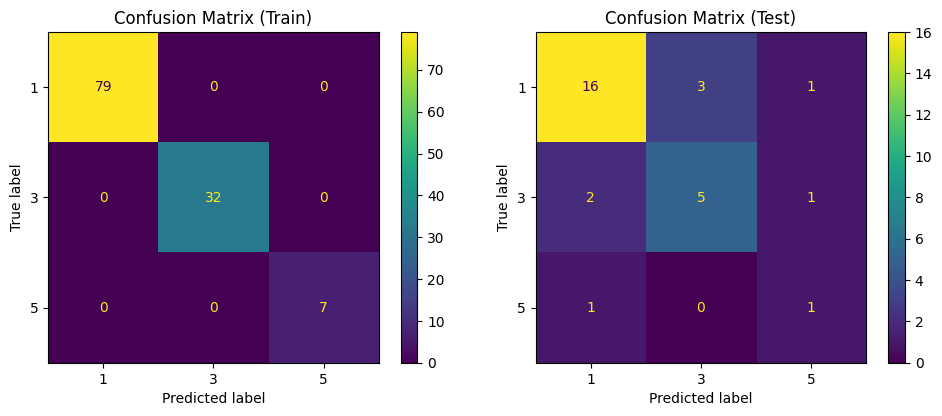

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)
pipeline.fit(X_train, y_train, model__sample_weight=sample_weight_train)
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC (OVR Macro): {roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro'):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axes[0])
axes[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[1])
axes[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

## Tuning

In [71]:
k_options = [k for k in [5, 7, 9, 11] if k <= X_fe.shape[1]]
param_grid = {
    "select__k": k_options,
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 4],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__max_features": [None, "sqrt"]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train, y_train, model__sample_weight=sample_weight_train)
grid.best_params_, grid.best_score_

({'model__learning_rate': 0.03,
  'model__max_depth': 2,
  'model__max_features': None,
  'model__min_samples_leaf': 4,
  'model__min_samples_split': 6,
  'model__n_estimators': 100,
  'model__subsample': 0.9,
  'select__k': 5},
 np.float64(0.5900349113252339))

## Evaluation

Accuracy: 0.7333
F1 Macro: 0.5927
Balanced Accuracy: 0.6167
ROC-AUC (OVR Macro): 0.7615
              precision    recall  f1-score   support

           1       0.81      0.85      0.83        20
           3       0.80      0.50      0.62         8
           5       0.25      0.50      0.33         2

    accuracy                           0.73        30
   macro avg       0.62      0.62      0.59        30
weighted avg       0.77      0.73      0.74        30



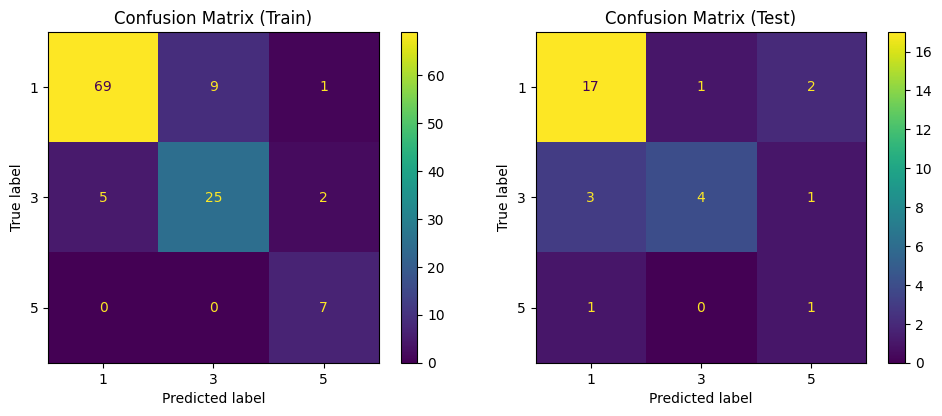

In [72]:
best_model = grid.best_estimator_
best_train_pred = best_model.predict(X_train)
best_pred = best_model.predict(X_test)
best_proba = best_model.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, best_pred):.4f}")
print(f"F1 Macro: {f1_score(y_test, best_pred, average='macro'):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, best_pred):.4f}")
print(f"ROC-AUC (OVR Macro): {roc_auc_score(y_test, best_proba, multi_class='ovr', average='macro'):.4f}")
print(classification_report(y_test, best_pred))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_train, best_train_pred, ax=axes[0])
axes[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_predictions(y_test, best_pred, ax=axes[1])
axes[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

## Cross Validation (SMOTE)

In [73]:
smote_pipeline = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("feature_engineer", FeatureEngineer(feature_names=X.columns)),
    ("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42)),
    ("select", SelectKBest(mutual_info_classif, k=k_best)),
    ("model", GradientBoostingClassifier(random_state=42))
])

smote_cv_results = cross_validate(
    smote_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

pd.DataFrame(smote_cv_results).agg(["mean", "std"])

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted,test_roc_auc_ovr_macro
mean,0.139127,0.004815,0.663908,0.562807,0.520367,0.662058,0.708914
std,0.007468,0.000391,0.144628,0.204517,0.188946,0.145037,0.178471


## Evaluation (SMOTE)

Accuracy: 0.7667
F1 Macro: 0.6583
Balanced Accuracy: 0.6583
ROC-AUC (OVR Macro): 0.7316


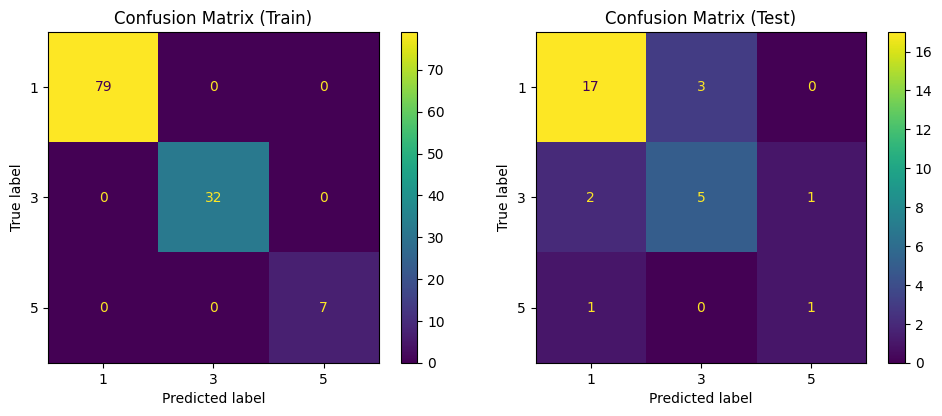

In [74]:
smote_pipeline.fit(X_train, y_train)
smote_train_pred = smote_pipeline.predict(X_train)
smote_pred = smote_pipeline.predict(X_test)
smote_proba = smote_pipeline.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, smote_pred):.4f}")
print(f"F1 Macro: {f1_score(y_test, smote_pred, average='macro'):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, smote_pred):.4f}")
print(f"ROC-AUC (OVR Macro): {roc_auc_score(y_test, smote_proba, multi_class='ovr', average='macro'):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_train, smote_train_pred, ax=axes[0])
axes[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_predictions(y_test, smote_pred, ax=axes[1])
axes[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

## SVM (RBF) - Cross Validation

In [75]:
svm_pipeline = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("feature_engineer", FeatureEngineer(feature_names=X.columns)),
    ("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42)),
    ("select", SelectKBest(mutual_info_classif, k=k_best)),
    ("model", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])

svm_cv_results = cross_validate(
    svm_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

pd.DataFrame(svm_cv_results).agg(["mean", "std"])

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted,test_roc_auc_ovr_macro
mean,0.01926,0.004831,0.649885,0.646316,0.566437,0.666749,0.783083
std,0.00468,0.000726,0.091766,0.085178,0.084714,0.073920,0.095820


## SVM (RBF) - Evaluation

Accuracy: 0.7000
F1 Macro: 0.5670
Balanced Accuracy: 0.6000
ROC-AUC (OVR Macro): 0.7703


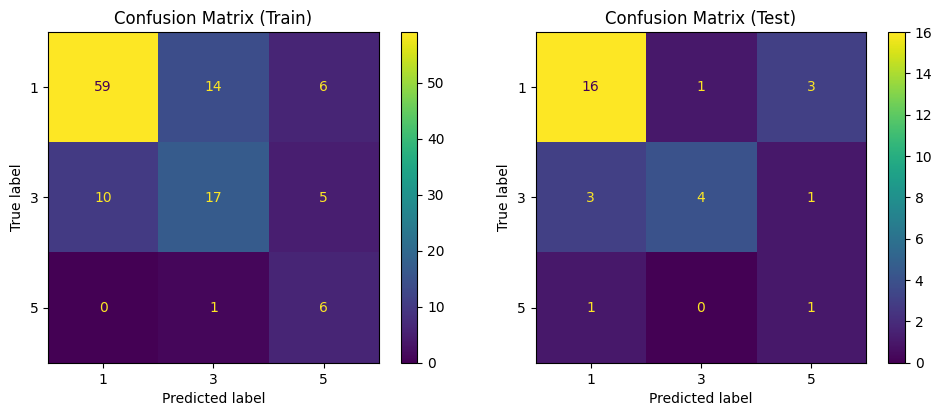

In [76]:
svm_pipeline.fit(X_train, y_train)
svm_train_pred = svm_pipeline.predict(X_train)
svm_pred = svm_pipeline.predict(X_test)
svm_proba = svm_pipeline.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
print(f"F1 Macro: {f1_score(y_test, svm_pred, average='macro'):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, svm_pred):.4f}")
print(f"ROC-AUC (OVR Macro): {roc_auc_score(y_test, svm_proba, multi_class='ovr', average='macro'):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_train, svm_train_pred, ax=axes[0])
axes[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_predictions(y_test, svm_pred, ax=axes[1])
axes[1].set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

## Threshold Tuning (F1 Macro)

Thresholds: {np.int64(1): np.float64(0.21), np.int64(3): np.float64(0.6), np.int64(5): np.float64(0.33)}
Accuracy (Thresholded): 0.7333
F1 Macro (Thresholded): 0.5927
Balanced Accuracy (Thresholded): 0.6167
ROC-AUC (OVR Macro): 0.7615


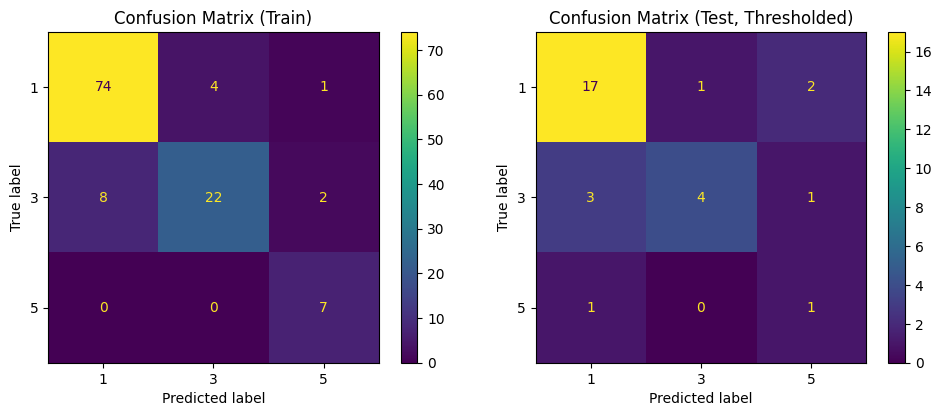

In [77]:
def tune_thresholds_f1_macro(y_true, y_proba, classes, steps=101):
    thresholds = {}
    for idx, cls in enumerate(classes):
        y_binary = (y_true == cls).astype(int)
        best_threshold = 0.5
        best_score = -1.0
        for t in np.linspace(0.0, 1.0, steps):
            y_pred = (y_proba[:, idx] >= t).astype(int)
            score = f1_score(y_binary, y_pred)
            if score > best_score:
                best_score = score
                best_threshold = t
        thresholds[cls] = best_threshold
    return thresholds

def predict_with_thresholds(y_proba, thresholds, classes):
    threshold_array = np.array([thresholds[cls] for cls in classes])
    meets = y_proba >= threshold_array
    preds = []
    for row, meets_row in zip(y_proba, meets):
        if meets_row.any():
            candidate_idx = np.where(meets_row)[0]
            best_idx = candidate_idx[np.argmax(row[candidate_idx])]
        else:
            best_idx = np.argmax(row)
        preds.append(classes[best_idx])
    return np.array(preds)

best_model = grid.best_estimator_
classes = np.unique(y_train)
cv_proba = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1,
    params={"model__sample_weight": sample_weight_train}
)
thresholds = tune_thresholds_f1_macro(y_train, cv_proba, classes)
train_proba_threshold = best_model.predict_proba(X_train)
best_proba_threshold = best_model.predict_proba(X_test)
thresholded_train_pred = predict_with_thresholds(train_proba_threshold, thresholds, classes)
thresholded_pred = predict_with_thresholds(best_proba_threshold, thresholds, classes)

print(f"Thresholds: {thresholds}")
print(f"Accuracy (Thresholded): {accuracy_score(y_test, thresholded_pred):.4f}")
print(f"F1 Macro (Thresholded): {f1_score(y_test, thresholded_pred, average='macro'):.4f}")
print(f"Balanced Accuracy (Thresholded): {balanced_accuracy_score(y_test, thresholded_pred):.4f}")
print(f"ROC-AUC (OVR Macro): {roc_auc_score(y_test, best_proba_threshold, multi_class='ovr', average='macro'):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_train, thresholded_train_pred, ax=axes[0])
axes[0].set_title("Confusion Matrix (Train)")
ConfusionMatrixDisplay.from_predictions(y_test, thresholded_pred, ax=axes[1])
axes[1].set_title("Confusion Matrix (Test, Thresholded)")
plt.tight_layout()
plt.show()